In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42

In [3]:
df = pd.read_csv('./train_ml.csv')

In [4]:
test_df = pd.read_csv('./new_test_ml.csv', index_col=0)

In [5]:
df.head(n=3)

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54


In [6]:
test_df.head()

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41


In [7]:
df.shape

(75000, 4)

In [8]:
# удаляю все строки из обучающих данных, в которых нет оценки

na_indexes = df[df.grades.isna()].index
df.drop(index=na_indexes, inplace=True)

In [9]:
df.grades = df.grades.astype(np.int8)
df.grades.nbytes

51476

In [10]:
import datetime

df.date = df.date.apply(lambda i: datetime.datetime.strptime(i, '%d.%m.%Y %H:%M'))
df['bank_name_len'] = df.bank.apply(lambda i: len(i))
df['feed_words'] = df.feeds.apply(lambda i: i.split().__len__())
df['feed_len'] = df.feeds.apply(lambda i: len(i))
df['day_of_week'] = df.date.apply(lambda i: i.isoweekday())
df['is_workday'] = df.day_of_week < 6
df['is_friday'] = df.day_of_week == 5
df['is_monday'] = df.day_of_week == 1

# для тестового датасета
test_df.date = test_df.date.apply(lambda i: datetime.datetime.strptime(i, '%d.%m.%Y %H:%M'))
test_df['bank_name_len'] = test_df.bank.apply(lambda i: len(i))
test_df['feed_words'] = test_df.feeds.apply(lambda i: i.split().__len__())
test_df['feed_len'] = test_df.feeds.apply(lambda i: len(i))
test_df['day_of_week'] = test_df.date.apply(lambda i: i.isoweekday())
test_df['is_workday'] = test_df.day_of_week < 6
test_df['is_friday'] = test_df.day_of_week == 5
test_df['is_monday'] = test_df.day_of_week == 1

df.sample(5)


,bank,feeds,grades,date,bank_name_len,feed_words,feed_len,day_of_week,is_workday,is_friday,is_monday
56618,fk_otkritie,Обратился в отделение в связи с закрытием счет...,1,2019-11-19 17:13:00,11,66,414,2,True,False,False
50287,tcs,С января 2017 года стал клиентом Тинькофф банк...,4,2017-05-12 08:40:00,3,440,2873,5,True,True,False
62050,investtorgbank,Мы являемся заемщиками в Инвестторгбанке по ип...,1,2013-11-19 12:41:00,14,88,620,2,True,False,False
39779,trust,12.04.2017 мною был написано заявление на доср...,1,2017-05-30 10:31:00,5,237,1558,2,True,False,False
68966,tcs,Дебетовой картой Тинькофф Блэк пользуюсь не пе...,3,2019-11-04 15:10:00,3,236,1503,1,True,False,True


In [11]:
df['mean_word_len'] = df.feeds.apply(lambda x: np.mean([i.__len__() for i in x.split()]))
df['mean_word_len2'] = df.feed_len / df.feed_words


test_df['mean_word_len'] = test_df.feeds.apply(lambda x: np.mean([i.__len__() for i in x.split()]))
test_df['mean_word_len2'] = test_df.feed_len / test_df.feed_words

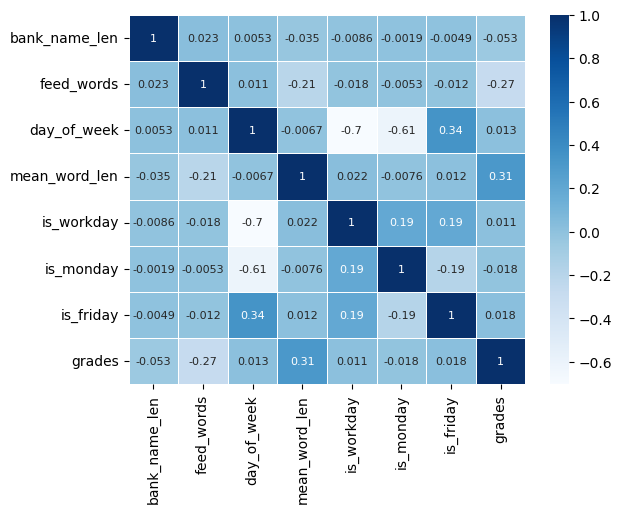

In [199]:
column_names = ['bank_name_len', 'feed_words', 'day_of_week', 'mean_word_len', 'is_workday', 'is_monday', 'is_friday']
corr_data = df[column_names +['grades']]
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(data=corr_data.corr(), annot=True, annot_kws=dict(size=8), cmap='Blues', linewidths=0.5)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[column_names], 
    df.grades, 
    test_size=0.2,
    random_state=RANDOM_STATE,
)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
test_X = scaler.transform(test_df[column_names])
test_X.shape

(17220, 7)

<Axes: >

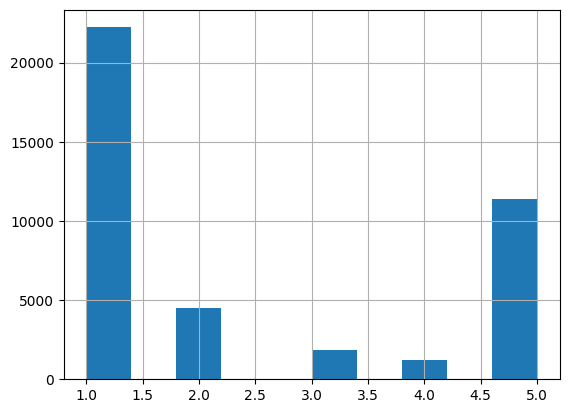

In [16]:
y_train.hist()

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression( solver='lbfgs')
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)[:, 1]

In [18]:
pd.Series(lr_pred).value_counts(normalize=True)

1    0.793512
5    0.206488
Name: proportion, dtype: float64

In [179]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


def print_results(test_data, predictions):
    print(f"Classification reposrt:\n{classification_report(test_data, predictions)}")
    print(f"Confusion matrix:\n{confusion_matrix(test_data, predictions)}")
    print(f"Accuracy score: {accuracy_score(test_data, predictions)*100:2.1f}%")
    print(f"f1 score: {f1_score(test_data, predictions, average='weighted')*100:2.1f}%")

print_results(y_test, lr_pred)

Classification reposrt:
              precision    recall  f1-score   support

           1       0.54      0.80      0.65      5548
           2       0.00      0.00      0.00      1127
           3       0.00      0.00      0.00       471
           4       0.00      0.00      0.00       304
           5       0.30      0.22      0.25      2846

    accuracy                           0.49     10296
   macro avg       0.17      0.20      0.18     10296
weighted avg       0.37      0.49      0.42     10296

Confusion matrix:
[[4437    0    0    0 1111]
 [ 900    0    0    0  227]
 [ 372    0    0    0   99]
 [ 243    0    0    0   61]
 [2218    0    0    0  628]]
Accuracy score: 49.2%
f1 score: 41.8%


/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
bias_pred = np.ones_like(y_test)
print(f"BIAS Accuracy score: {accuracy_score(y_test, bias_pred)*100:2.1f}%")
print(f"BIAS f1 score: {f1_score(y_test, bias_pred, average='weighted')*100:2.1f}%")

BIAS Accuracy score: 53.5%
BIAS f1 score: 37.3%


In [21]:
test_df_pred = lr.predict(test_X)


In [22]:
test_index = test_df.index
answer = pd.DataFrame(data=test_df_pred, index=test_index, columns=['grades'])
answer.to_csv('my_answer_lr.csv', index_label='inds')

In [23]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()

In [24]:
cb.fit(X_train, y_train, )

Learning rate set to 0.095647
0:	learn: 1.4975624	total: 54.7ms	remaining: 54.6s
1:	learn: 1.4165623	total: 61.4ms	remaining: 30.7s
2:	learn: 1.3539177	total: 69.6ms	remaining: 23.1s
3:	learn: 1.3037371	total: 76.7ms	remaining: 19.1s
4:	learn: 1.2631421	total: 84.1ms	remaining: 16.7s
5:	learn: 1.2299468	total: 91.9ms	remaining: 15.2s
6:	learn: 1.2027331	total: 99.2ms	remaining: 14.1s
7:	learn: 1.1801194	total: 107ms	remaining: 13.3s
8:	learn: 1.1613961	total: 114ms	remaining: 12.6s
9:	learn: 1.1455658	total: 122ms	remaining: 12.1s
10:	learn: 1.1301361	total: 130ms	remaining: 11.7s
11:	learn: 1.1181826	total: 137ms	remaining: 11.3s
12:	learn: 1.1084809	total: 143ms	remaining: 10.9s
13:	learn: 1.0990228	total: 150ms	remaining: 10.6s
14:	learn: 1.0915031	total: 157ms	remaining: 10.3s
15:	learn: 1.0851564	total: 164ms	remaining: 10.1s
16:	learn: 1.0793875	total: 171ms	remaining: 9.89s
17:	learn: 1.0738387	total: 179ms	remaining: 9.75s
18:	learn: 1.0690739	total: 186ms	remaining: 9.59s
19:	

In [25]:
from sklearn.metrics import f1_score
cb_pred = cb.predict(X_test)
print(f"CatBoost Classification report:\n{classification_report(y_test, cb_pred)}")
print(f"CatBoost accuracy: {accuracy_score(y_test, cb_pred)*100:2.1f}%")
print(f"CatBoost f1 score: {f1_score(y_test, cb_pred, average='weighted')*100:2.1f}%")

CatBoost Classification report:
              precision    recall  f1-score   support

           1       0.62      0.89      0.73      5507
           2       0.00      0.00      0.00      1131
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00       288
           5       0.63      0.52      0.57      2858

    accuracy                           0.62     10296
   macro avg       0.25      0.28      0.26     10296
weighted avg       0.51      0.62      0.55     10296

CatBoost accuracy: 62.0%
CatBoost f1 score: 54.8%


/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(*sorted(zip(column_names, cb.get_feature_importance()), key=lambda i: i[1], reverse=True), sep='\n')

('feed_words', 30.100191704185754)
('mean_word_len', 26.873854474786814)
('bank_name_len', 25.948420868559655)
('day_of_week', 12.385536318311306)
('is_friday', 2.468833584039685)
('is_workday', 1.4733255975977821)
('is_monday', 0.7498374525190077)


In [27]:
pd.Series(cb_pred[:, 0]).value_counts()

1    7963
5    2332
4       1
Name: count, dtype: int64

<Axes: ylabel='Count'>

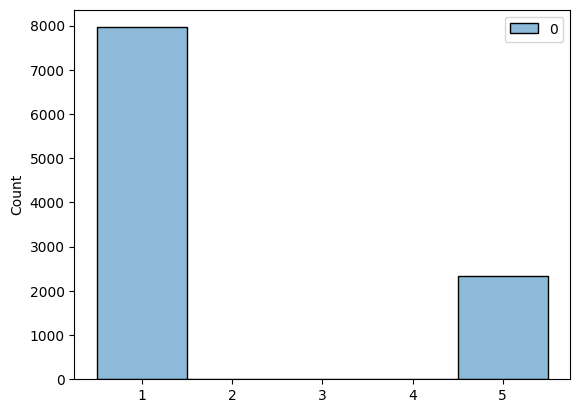

In [28]:
sns.histplot(data=cb_pred, discrete=True)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams

In [30]:
sent = df.feeds.iloc[5]
ngrams_ = ngrams(sent.split(), 2)
list(ngrams_)

[('Познакомился', 'с'),
 ('с', 'ВТБ24'),
 ('ВТБ24', 'в'),
 ('в', 'конце'),
 ('конце', '2011'),
 ('2011', 'года,'),
 ('года,', 'практически'),
 ('практически', 'тогда'),
 ('тогда', 'у'),
 ('у', 'меня'),
 ('меня', 'и'),
 ('и', 'началась'),
 ('началась', 'кредитная'),
 ('кредитная', 'история'),
 ('история', '(ипотечная).'),
 ('(ипотечная).', 'А'),
 ('А', 'началось'),
 ('началось', 'все'),
 ('все', 'с'),
 ('с', 'того,'),
 ('того,', 'что'),
 ('что', 'почти'),
 ('почти', 'все'),
 ('все', 'банки'),
 ('банки', 'отказали'),
 ('отказали', 'мне'),
 ('мне', 'в'),
 ('в', 'ипотеке'),
 ('ипотеке', 'с'),
 ('с', 'моей'),
 ('моей', '"0"'),
 ('"0"', 'кредитной'),
 ('кредитной', 'историей.'),
 ('историей.', 'Просил'),
 ('Просил', 'много'),
 ('много', '-'),
 ('-', 'дали'),
 ('дали', 'мало,'),
 ('мало,', 'но'),
 ('но', 'хоть'),
 ('хоть', 'что-то.'),
 ('что-то.', 'С'),
 ('С', 'того'),
 ('того', 'времени'),
 ('времени', 'неспешно'),
 ('неспешно', 'оплачиваю'),
 ('оплачиваю', '25-ти'),
 ('25-ти', 'летнюю'),
 (

In [31]:
feeds = df.feeds

In [32]:
from nltk.tokenize import RegexpTokenizer

tknzr = RegexpTokenizer(r'[А-Яа-яA-z]+')
words = tknzr.tokenize('12312')
words

[]

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# удаляем стоп слова
from nltk.corpus import stopwords

stops = stopwords.words('russian')

def text2tokens(text, tokenizer=__import__('nltk').tokenize.word_tokenize):
    text = text.casefold()
    # return tokenizer(text)
    return tokenizer.tokenize(text)

def remove_stopwords(tokens, stopwords=__import__('nltk').corpus.stopwords.words('russian')):
    return [t for t in tokens if t not in stopwords]

def text_processing(text):
    tokens = text2tokens(text, tokenizer=RegexpTokenizer(r'[А-Яа-яA-z]+'))
    tokens = remove_stopwords(tokens)
    return " ".join(tokens)


from pymystem3 import Mystem
mystem = Mystem()
def lemmatize_text(text):
    try:
        pass
        # tokens = text2tokens(text, tokenizer=RegexpTokenizer(r'[А-Яа-яA-z]+'))
    except Exception as e:
        print('text2tokens: ', text.split(), str(e))

    try:
        if text:
            lemmas = mystem.lemmatize(text)
        else:
            lemmas = []
        #lemmas = mystem.lemmatize(" ".join(tokens))
    except Exception as e:
        print(f"lemmatize: {text}", str(e))
    lemmas = remove_stopwords(lemmas)
    return ''.join([i for i  in lemmas])
    


# text_processing(feed)
# lemmatize_text(text_processing(feed))

In [35]:
from multiprocessing import Pool
from tqdm import tqdm

def f(text):
    return lemmatize_text(text_processing(text))

N = df.feeds.__len__()#1000
lemmas = []
# for i in tqdm(range(N)):
#     lemmas.append(lemmatize_text(text_processing(df.feeds.iloc[i])))

# with Pool(8) as p:
#     lemmas = list(
#         tqdm(
#             p.imap(
#                 f, 
#                 df.feeds.iloc[:N]
#             ),
#             total=N,
#         )
#     )

In [36]:
from functools import lru_cache
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

regex = re.compile(r'[А-Яа-яA-z]+')

def words_only(text, regex=re.compile(r'[А-Яа-яA-z]+')):
    try:
        return regex.findall(text.casefold())
    except:
        return []

@lru_cache(maxsize=512)
def lemmatize_token(token, pymorph=__import__('pymorphy2').MorphAnalyzer()):
    return pymorph.parse(token)[0].normal_form

def lemmatize_tokens(tokens):
    return [lemmatize_token(token) for token in tokens]

def remove_stopwords(lemmas, stopwords=__import__('nltk').corpus.stopwords.words('russian')):
    return [w for w in lemmas if w not in stopwords]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_tokens(tokens)
    return ' '.join(remove_stopwords(lemmas))

In [37]:
from multiprocessing import Pool

N = len(df)
with Pool(16) as p:
    lemmas = list(
        tqdm(
            p.imap(clean_text, df.feeds[:N]),
            total = N
        )
    )



100%|██████████| 51476/51476 [01:07<00:00, 758.42it/s]


In [38]:
test_N = len(test_df)
with Pool(18) as p:
    test_lemmas = list(
        tqdm(
            p.imap(
                clean_text,
                test_df.feeds[:test_N],
            ),
            total = test_N
        )
    )
len(test_lemmas)

100%|██████████| 17220/17220 [00:23<00:00, 731.65it/s]


17220

In [39]:
test_df['lemmas'] = test_lemmas
df['lemmas'] = lemmas

In [43]:
column_names + ['lemmas']

['bank_name_len',
 'feed_words',
 'day_of_week',
 'mean_word_len',
 'is_workday',
 'is_monday',
 'is_friday',
 'lemmas']

In [200]:
numerical_columns = column_names
column_names.append('lemmas')
column_names.append('feeds')
column_names

['bank_name_len',
 'feed_words',
 'day_of_week',
 'mean_word_len',
 'is_workday',
 'is_monday',
 'is_friday',
 'lemmas',
 'feeds']

In [201]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[column_names], df.grades, test_size=0.2, random_state=RANDOM_STATE, stratify=df.grades)
print(f"{X_train.shape = }, {X_test.shape = }")
print(f"{y_train.shape = }, {y_test.shape = }")

X_train.shape = (41180, 9), X_test.shape = (10296, 9)
y_train.shape = (41180,), y_test.shape = (10296,)


In [202]:
X_train[numerical_columns].shape

(41180, 9)

In [60]:
# BoW - Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1, 1))
vec.fit(X_train.lemmas)


CountVectorizer()

In [66]:
bow = vec.transform(X_train.lemmas)

In [78]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=RANDOM_STATE,  max_iter=100)

In [79]:
log_clf.fit(bow, y_train)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [84]:
log_pred = log_clf.predict(vec.transform(X_test.lemmas))
log_pred_proba = log_clf.predict_proba(vec.transform(X_test.lemmas))[:, 1]

<Axes: >

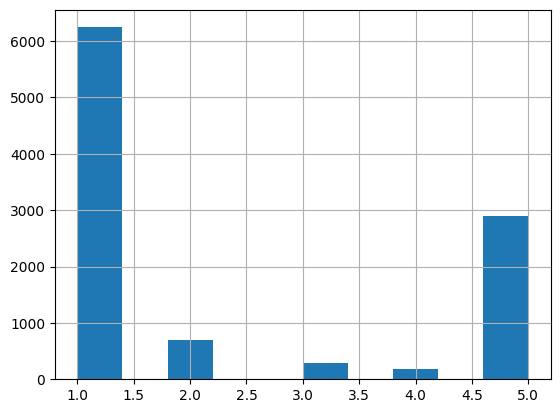

In [85]:
pd.Series(log_pred).hist()

In [86]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

In [88]:
from sklearn.metrics import confusion_matrix
print(f"Classification reposrt:\n{classification_report(y_test, log_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, log_pred)}")
print(f"accuracy score: {accuracy_score(y_test, log_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, log_pred, average='weighted')*100:2.1f}%")

Classification reposrt:
              precision    recall  f1-score   support

           1       0.78      0.88      0.83      5548
           2       0.20      0.13      0.16      1127
           3       0.14      0.09      0.11       471
           4       0.21      0.12      0.16       304
           5       0.89      0.90      0.90      2846

    accuracy                           0.74     10296
   macro avg       0.45      0.42      0.43     10296
weighted avg       0.70      0.74      0.72     10296

Confusion matrix:
[[4867  426  118   27  110]
 [ 864  141   72   13   37]
 [ 293   77   41   28   32]
 [  72   19   31   38  144]
 [ 148   25   28   72 2573]]
accuracy score: 74.4%
f1 score: 71.9%


In [ ]:
# Функция для отправки тестовых данных
def make_submission(classificator, vectorizer, test_data, filename='my_submission.csv'):
    test_bow = vectorizer.transform(test_data)
    test_predict = classificator.predict(test_bow)

    test_answer = pd.DataFrame(test_predict, columns=['grades'], index=test_df.index)
    test_answer.to_csv(filename, index_label='inds')

In [214]:
# создаю тестовые данные
make_submission(
    vectorizer=vec,
    test_data=test_df.lemmas,
    classificator=log_clf,
    filename='my_answer_count_vectorizer_1_1_log.csv',
)


In [91]:
# Использую для векторизации ngram_range=(2, 2)

from sklearn.feature_extraction.text import CountVectorizer

vec2 = CountVectorizer(ngram_range=(2, 2))
bow2 = vec2.fit_transform(X_train.lemmas)


In [92]:
log2 = LogisticRegression( max_iter=100, verbose=2)
log2.fit(bow2, y_train,)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [93]:
log2_pred = log2.predict(vec2.transform(X_test.lemmas))
log2_pred_proba = log2.predict_proba(vec2.transform(X_test.lemmas))[:,1]

In [94]:
from sklearn.metrics import accuracy_score
print(f"Classification report:\n{classification_report(y_test, log2_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, log2_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, log2_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, log2_pred, average='weighted')*100:2.1f}%")

Classification report:
              precision    recall  f1-score   support

           1       0.74      0.96      0.84      5548
           2       0.25      0.05      0.08      1127
           3       0.14      0.01      0.02       471
           4       0.24      0.01      0.02       304
           5       0.89      0.90      0.89      2846

    accuracy                           0.77     10296
   macro avg       0.45      0.39      0.37     10296
weighted avg       0.69      0.77      0.71     10296

Confusion matrix:
[[5308  118   19    2  101]
 [1024   56    7    2   38]
 [ 392   36    5    4   34]
 [ 142   10    2    4  146]
 [ 282    8    3    5 2548]]
Accuracy score: 76.9%
f1 score: 70.8%


In [95]:
# ngram range= (1, 2)

vec12 = CountVectorizer(ngram_range=(1, 2))
bow12 = vec12.fit_transform(X_train.lemmas)

In [96]:
bow.shape, bow2.shape, bow12.shape

((41180, 55975), (41180, 1469147), (41180, 1525122))

In [97]:
log12 = LogisticRegression(max_iter=200)
log12.fit(bow12, y_train)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [98]:
bow12_test = vec12.transform(X_test.lemmas)
log12_pred = log12.predict(bow12_test)
log12_pred_proba = log12.predict_proba(bow12_test)[:,1]

In [99]:
from sklearn.metrics import accuracy_score
print(f"Classification reposrt:\n{classification_report(y_test, log12_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, log12_pred)}")
print(f"Accuracy: {accuracy_score(y_test, log12_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, log12_pred, average='weighted')*100:2.1f}%")

Classification reposrt:
              precision    recall  f1-score   support

           1       0.77      0.93      0.85      5548
           2       0.26      0.10      0.14      1127
           3       0.21      0.07      0.11       471
           4       0.24      0.08      0.12       304
           5       0.90      0.92      0.91      2846

    accuracy                           0.77     10296
   macro avg       0.48      0.42      0.43     10296
weighted avg       0.71      0.77      0.73     10296

Confusion matrix:
[[5177  228   58   11   74]
 [ 935  110   35   14   33]
 [ 324   60   34   19   34]
 [  90   13   21   24  156]
 [ 157   13   15   30 2631]]
Accuracy: 77.5%
f1 score: 73.2%


In [100]:
# сделаем тестовые данные для CountVectorizer(ngram_range=(1, 2))
test_bow = vec12.transform(test_df.lemmas)
test_predict = log12.predict(test_bow)

test_answer = pd.DataFrame(test_predict, columns=['grades'], index=test_df.index)
test_answer.to_csv('my_submission_count_vectorizer_1_2_log.csv', index_label='inds')

In [101]:
# import microsoft boost classifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)

ada.fit(bow12, y_train, )

AdaBoostClassifier(n_estimators=100)

In [102]:
ada_pred = ada.predict(bow12_test)

print(f"Classification reposrt:\n{classification_report(y_test, ada_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, ada_pred)}")
print(f"Accuracy: {accuracy_score(y_test, ada_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, ada_pred, average='weighted')*100:2.1f}%")

Classification reposrt:
              precision    recall  f1-score   support

           1       0.74      0.96      0.83      5548
           2       0.74      0.02      0.03      1127
           3       0.33      0.00      0.01       471
           4       0.31      0.06      0.10       304
           5       0.83      0.86      0.85      2846

    accuracy                           0.76     10296
   macro avg       0.59      0.38      0.36     10296
weighted avg       0.73      0.76      0.69     10296

Confusion matrix:
[[5332    3    1   13  199]
 [1019   17    1   10   80]
 [ 400    1    2    6   62]
 [ 123    1    1   19  160]
 [ 370    1    1   13 2461]]
Accuracy: 76.1%
f1 score: 69.0%


In [103]:
# AdaBoost показал чуть худшую метрику

In [104]:
# теперь веткоризавтор на основе подсчета tf-idf
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

tf_vec1 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
tf_bow1 = tf_vec1.fit_transform(X_train.lemmas)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [105]:
tf_log1 = LogisticRegression(max_iter=300)
tf_log1.fit(tf_bow1, y_train)

LogisticRegression(max_iter=300)

In [106]:
tf_bow1_test = tf_vec1.transform(X_test.lemmas)
tf_log1_pred = tf_log1.predict(tf_bow1_test)
tf_log1_pred_proba = tf_log1.predict_proba(tf_bow1_test)


In [107]:
print(f"Classification reposrt:\n{classification_report(y_test, tf_log1_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, tf_log1_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, tf_log1_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, tf_log1_pred, average='weighted')*100:2.1f}%")

Classification reposrt:
              precision    recall  f1-score   support

           1       0.75      0.98      0.85      5548
           2       0.27      0.02      0.05      1127
           3       0.30      0.01      0.03       471
           4       0.41      0.02      0.04       304
           5       0.90      0.92      0.91      2846

    accuracy                           0.79     10296
   macro avg       0.53      0.39      0.38     10296
weighted avg       0.71      0.79      0.72     10296

Confusion matrix:
[[5443   39    5    1   60]
 [1070   28    2    0   27]
 [ 396   23    7    3   42]
 [ 117    7    8    7  165]
 [ 210    6    1    6 2623]]
Accuracy score: 78.7%
f1 score: 71.8%


In [108]:
test_tf_bow = tf_vec1.transform(test_df.lemmas)
test_tf_predict = tf_log1.predict(test_tf_bow)

test_answer = pd.DataFrame(test_tf_predict, columns=['grades'], index=test_df.index)
test_answer.to_csv('my_submission_tf_idf_ngrams=1_1.csv', index_label='inds')

In [109]:
# Ada Boost Classifier for tf-idf Vectorizer

ada = AdaBoostClassifier(n_estimators=100)
ada.fit(tf_bow1, y_train)


AdaBoostClassifier(n_estimators=100)

In [110]:
ada_pred = ada.predict(tf_bow1_test)
print(f"Ada Classification reposrt:\n{classification_report(y_test, ada_pred)}")
print(f"Ada Confusion matrix:\n{confusion_matrix(y_test, ada_pred)}")
print(f"Ada Accuracy score: {accuracy_score(y_test, ada_pred)*100:2.1f}%")
print(f"Ada f1 score: {f1_score(y_test, ada_pred, average='weighted')*100:2.1f}%")

Ada Classification reposrt:
              precision    recall  f1-score   support

           1       0.74      0.96      0.84      5548
           2       0.62      0.01      0.03      1127
           3       0.00      0.00      0.00       471
           4       0.32      0.07      0.12       304
           5       0.84      0.88      0.86      2846

    accuracy                           0.77     10296
   macro avg       0.50      0.39      0.37     10296
weighted avg       0.71      0.77      0.69     10296

Ada Confusion matrix:
[[5350    4    1   10  183]
 [1034   15    2   10   66]
 [ 389    3    0    5   74]
 [ 123    1    2   22  156]
 [ 327    1    2   22 2494]]
Ada Accuracy score: 76.5%
Ada f1 score: 69.5%


## tf-idf for ngram_range=(1, 2)

tf_vec12 = TfidfVectorizer(ngram_range=(1, 2), stop_words=['russian'], tokenizer=word_tokenize)
tf_vec12.fit(X_train.lemmas)

tf_bow12 = tf_vec12.transform(X_train.lemmas)
tf_bow12_test = tf_vec12.transform(X_test.lemmas)

# accuracy = 78.5, f1_score=70.9

tf_log12 = LogisticRegression(max_iter=100)
tf_log12.fit(tf_bow12, y_train)

tf_log12_pred = tf_log12.predict(tf_bow12_test)
print(f"Classification reposrt:\n{classification_report(y_test, tf_log12_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, tf_log12_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, tf_log12_pred)*100:2.1f}%")
print(f"f1 score: {f1_score(y_test, tf_log12_pred, average='weighted')*100:2.1f}%")

In [190]:
# использую символьные н-граммы

ch_vec = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3), )
ch_vec.fit(X_train.lemmas)
print(f" Размер словаря:{len(ch_vec.vocabulary_)}")

 Размер словаря:21426


In [191]:
bow_ch1 = ch_vec.transform(X_train.lemmas)
bow_ch1_test = ch_vec.transform(X_test.lemmas)

In [192]:
ch1_log = LogisticRegression(
    multi_class='multinomial', 
    n_jobs=16, 
    verbose=0, 
    max_iter=200,
    random_state=RANDOM_STATE
)

In [193]:
ch1_log.fit(bow_ch1, y_train)
None

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [194]:
ch1_pred = ch1_log.predict(bow_ch1_test)

print_results(y_test, ch1_pred)

Classification reposrt:
              precision    recall  f1-score   support

           1       0.77      0.93      0.84      5548
           2       0.23      0.07      0.10      1127
           3       0.15      0.05      0.08       471
           4       0.25      0.08      0.12       304
           5       0.88      0.92      0.90      2846

    accuracy                           0.77     10296
   macro avg       0.45      0.41      0.41     10296
weighted avg       0.69      0.77      0.72     10296

Confusion matrix:
[[5148  192   68   20  120]
 [ 957   76   44   11   39]
 [ 348   40   25   18   40]
 [  92   15   17   25  155]
 [ 179   14    9   28 2616]]
Accuracy score: 76.6%
f1 score: 71.9%


In [203]:
# применю н-граммы к оригинальному тексту
ch_vec = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3), tokenizer=word_tokenize)
ch_vec.fit(X_train.feeds)
print(f" Размер словаря:{len(ch_vec.vocabulary_)}")

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:563: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  warnings.warn(


 Размер словаря:72368


In [205]:
bow_ch2 = ch_vec.transform(X_train.lemmas)
bow_ch2_test = ch_vec.transform(X_test.lemmas)

In [206]:
ch2_log = LogisticRegression(
    multi_class='multinomial', 
    n_jobs=16, 
    verbose=0, 
    max_iter=200,
    random_state=RANDOM_STATE
)
ch2_log.fit(bow_ch2, y_train)
None

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [208]:
ch2_pred = ch2_log.predict(bow_ch2_test)

print_results(y_test, ch2_pred)

Classification reposrt:
              precision    recall  f1-score   support

           1       0.77      0.92      0.84      5548
           2       0.22      0.07      0.11      1127
           3       0.15      0.05      0.08       471
           4       0.25      0.09      0.13       304
           5       0.88      0.92      0.90      2846

    accuracy                           0.76     10296
   macro avg       0.45      0.41      0.41     10296
weighted avg       0.69      0.76      0.72     10296

Confusion matrix:
[[5119  214   68   22  125]
 [ 950   79   45   13   40]
 [ 346   38   25   18   44]
 [  87   17   22   27  151]
 [ 178   16    7   30 2615]]
Accuracy score: 76.4%
f1 score: 71.9%


In [212]:
make_submission(
    classificator=ch2_log,
    vectorizer=ch_vec,
    test_data=test_df.feeds,
    filename='my_submission_countvectorizer_ch3_3_feeds.csv'
)

In [220]:
vec = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(3, 3), 
    analyzer='char_wb',
    tokenizer=word_tokenize,
    )

vec.fit(X_train.feeds)
print(f"Размер словаря = {vec.vocabulary_.__len__()}")

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:563: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [225]:
print(f"Размер словаря = {vec.vocabulary_.__len__()}")

Размер словаря = 72368


In [228]:
bow = vec.transform(X_train.feeds)
bow_test = vec.transform(X_test.feeds)

In [229]:
lr = LogisticRegression(max_iter=500, multi_class='multinomial', random_state=RANDOM_STATE)
lr.fit(bow, y_train)
None

In [230]:
lr_pred = lr.predict(bow_test)
print_results(lr_pred, y_test)

Classification reposrt:
              precision    recall  f1-score   support

           1       0.98      0.75      0.85      7284
           2       0.02      0.21      0.03        89
           3       0.01      0.38      0.02        13
           4       0.01      0.31      0.03        13
           5       0.92      0.90      0.91      2897

    accuracy                           0.79     10296
   macro avg       0.39      0.51      0.37     10296
weighted avg       0.95      0.79      0.86     10296

Confusion matrix:
[[5455 1076  413  116  224]
 [  33   19   15   11   11]
 [   1    1    5    5    1]
 [   0    0    4    4    5]
 [  59   31   34  168 2605]]
Accuracy score: 78.6%
f1 score: 85.7%


In [231]:
make_submission(
    classificator=lr,
    vectorizer=vec,
    test_data=test_df.feeds,
    filename='my_submission_tfidf(3, 3)_logreg.csv',
)

In [232]:
# Векториризация TF-IDF 3х3 gj леммам

vec = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(3, 3), 
    analyzer='char_wb',
    tokenizer=word_tokenize,
    )

vec.fit(X_train.lemmas)
print(f"Размер словаря = {vec.vocabulary_.__len__()}")

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:563: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  warnings.warn(


Размер словаря = 21426


In [234]:
bow = vec.transform(X_train.lemmas)
bow_test = vec.transform(X_test.lemmas)

In [235]:
lr = LogisticRegression(max_iter=500, multi_class='multinomial', random_state=RANDOM_STATE)
lr.fit(bow, y_train)
None

In [ ]:
lr_pred = lr.predict(bow_test)
print_results(lr_pred, y_test)